# k-Nearest Neighbors (k-NN) Algorithm - Teaching Unit

## Introduction

The k-Nearest Neighbors (k-NN) algorithm is one of the simplest and most intuitive machine learning algorithms. It's a **lazy learning** algorithm that makes predictions based on the k closest data points in the feature space.

### Key Concepts:
- **Instance-based learning**: Uses stored instances to make predictions
- **Non-parametric**: Makes no assumptions about the underlying data distribution
- **Lazy learning**: No training phase - all computation happens during prediction
- **Distance-based**: Uses distance metrics to find nearest neighbors

### Applications:
- Classification (predicting categories)
- Regression (predicting continuous values)
- Recommendation systems
- Pattern recognition

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_blobs, load_iris, load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

## 1. How k-NN Works: The Intuition

### The Basic Idea
Imagine you're new to a neighborhood and want to know if it's safe. You might ask your k closest neighbors about their experience. If most of them say it's safe, you'd conclude it's probably safe.

k-NN works similarly:
1. **Store all training data** (no actual "training")
2. **For a new point**: Find the k closest training points
3. **For classification**: Take the majority vote of these k neighbors
4. **For regression**: Take the average of these k neighbors

### Key Parameters:
- **k**: Number of neighbors to consider
- **Distance metric**: How to measure "closeness" (Euclidean, Manhattan, etc.)
- **Weighting**: Should closer neighbors have more influence?

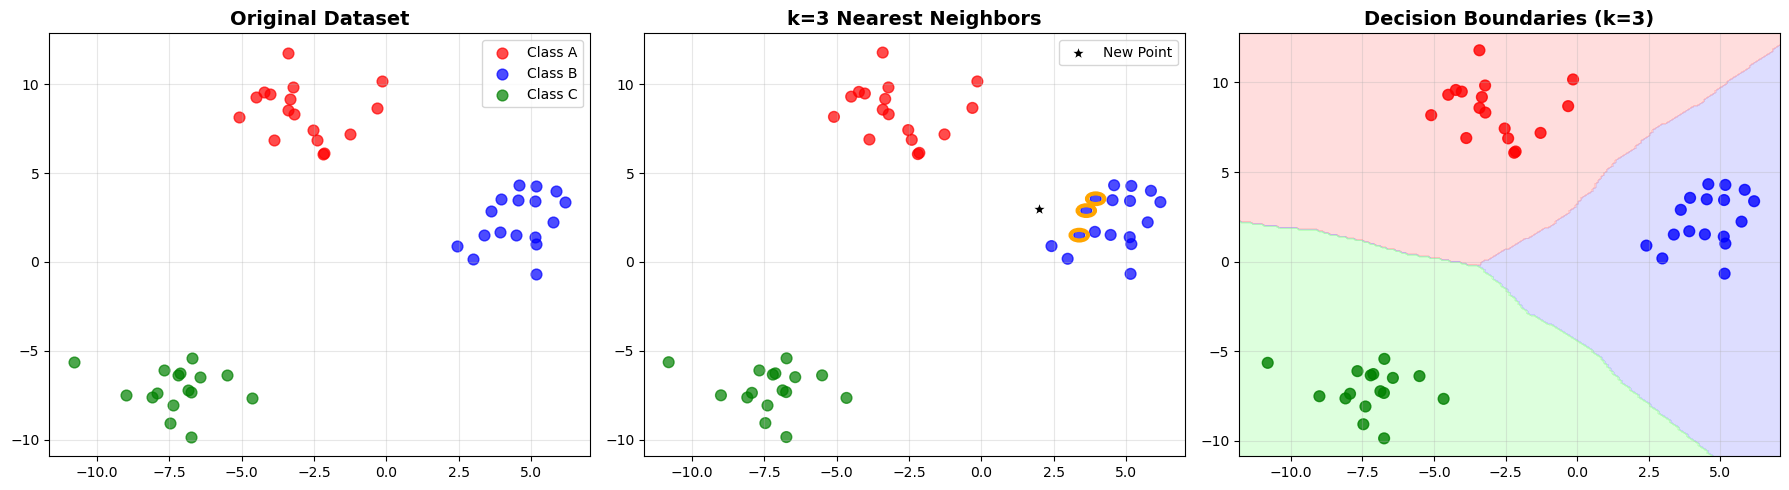

New point coordinates: [2 3]
3 nearest neighbors belong to classes: [1 1 1]
Predicted class: Class B (Class 1)
Voting: [0 3]


In [2]:
# Create a simple 2D dataset to visualize k-NN concept
X_simple, y_simple = make_blobs(n_samples=50, centers=3, n_features=2, 
                                cluster_std=1.5, random_state=42)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define colors for each class
colors = ['red', 'blue', 'green']
class_names = ['Class A', 'Class B', 'Class C']

# Plot 1: Original dataset
for i in range(3):
    mask = y_simple == i
    axes[0].scatter(X_simple[mask, 0], X_simple[mask, 1], 
                   c=colors[i], label=class_names[i], s=60, alpha=0.7)
axes[0].set_title('Original Dataset', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Show k=3 neighbors for a new point
new_point = np.array([[2, 3]])
axes[1].scatter(X_simple[:, 0], X_simple[:, 1], c=[colors[i] for i in y_simple], s=60, alpha=0.7)
axes[1].scatter(new_point[0, 0], new_point[0, 1], c='black', s=200, marker='*', 
               label='New Point', edgecolors='white', linewidth=2)

# Calculate distances and find 3 nearest neighbors
distances = np.sqrt(np.sum((X_simple - new_point) ** 2, axis=1))
nearest_indices = np.argsort(distances)[:3]

# Draw circles around nearest neighbors
for idx in nearest_indices:
    circle = plt.Circle((X_simple[idx, 0], X_simple[idx, 1]), 0.3, 
                       fill=False, color='orange', linewidth=3)
    axes[1].add_patch(circle)

axes[1].set_title('k=3 Nearest Neighbors', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Show decision boundaries
# Create a mesh to plot decision boundary
h = 0.1
x_min, x_max = X_simple[:, 0].min() - 1, X_simple[:, 0].max() + 1
y_min, y_max = X_simple[:, 1].min() - 1, X_simple[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Fit k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_simple, y_simple)

# Predict on the mesh
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
axes[2].contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
axes[2].scatter(X_simple[:, 0], X_simple[:, 1], c=[colors[i] for i in y_simple], s=60, alpha=0.8)
axes[2].set_title('Decision Boundaries (k=3)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the prediction for the new point
prediction = knn.predict(new_point)
neighbor_classes = y_simple[nearest_indices]
print(f"New point coordinates: {new_point[0]}")
print(f"3 nearest neighbors belong to classes: {neighbor_classes}")
print(f"Predicted class: {class_names[prediction[0]]} (Class {prediction[0]})")
print(f"Voting: {np.bincount(neighbor_classes)}")

## 2. The Impact of k: Finding the Right Balance

The choice of k is crucial in k-NN:
- **Small k (k=1)**: More sensitive to noise, complex decision boundaries, prone to overfitting
- **Large k**: Smoother decision boundaries, less sensitive to noise, but may underfit
- **Rule of thumb**: Start with k = √n (where n is the number of training samples)
- **Odd k**: Helps avoid ties in binary classification

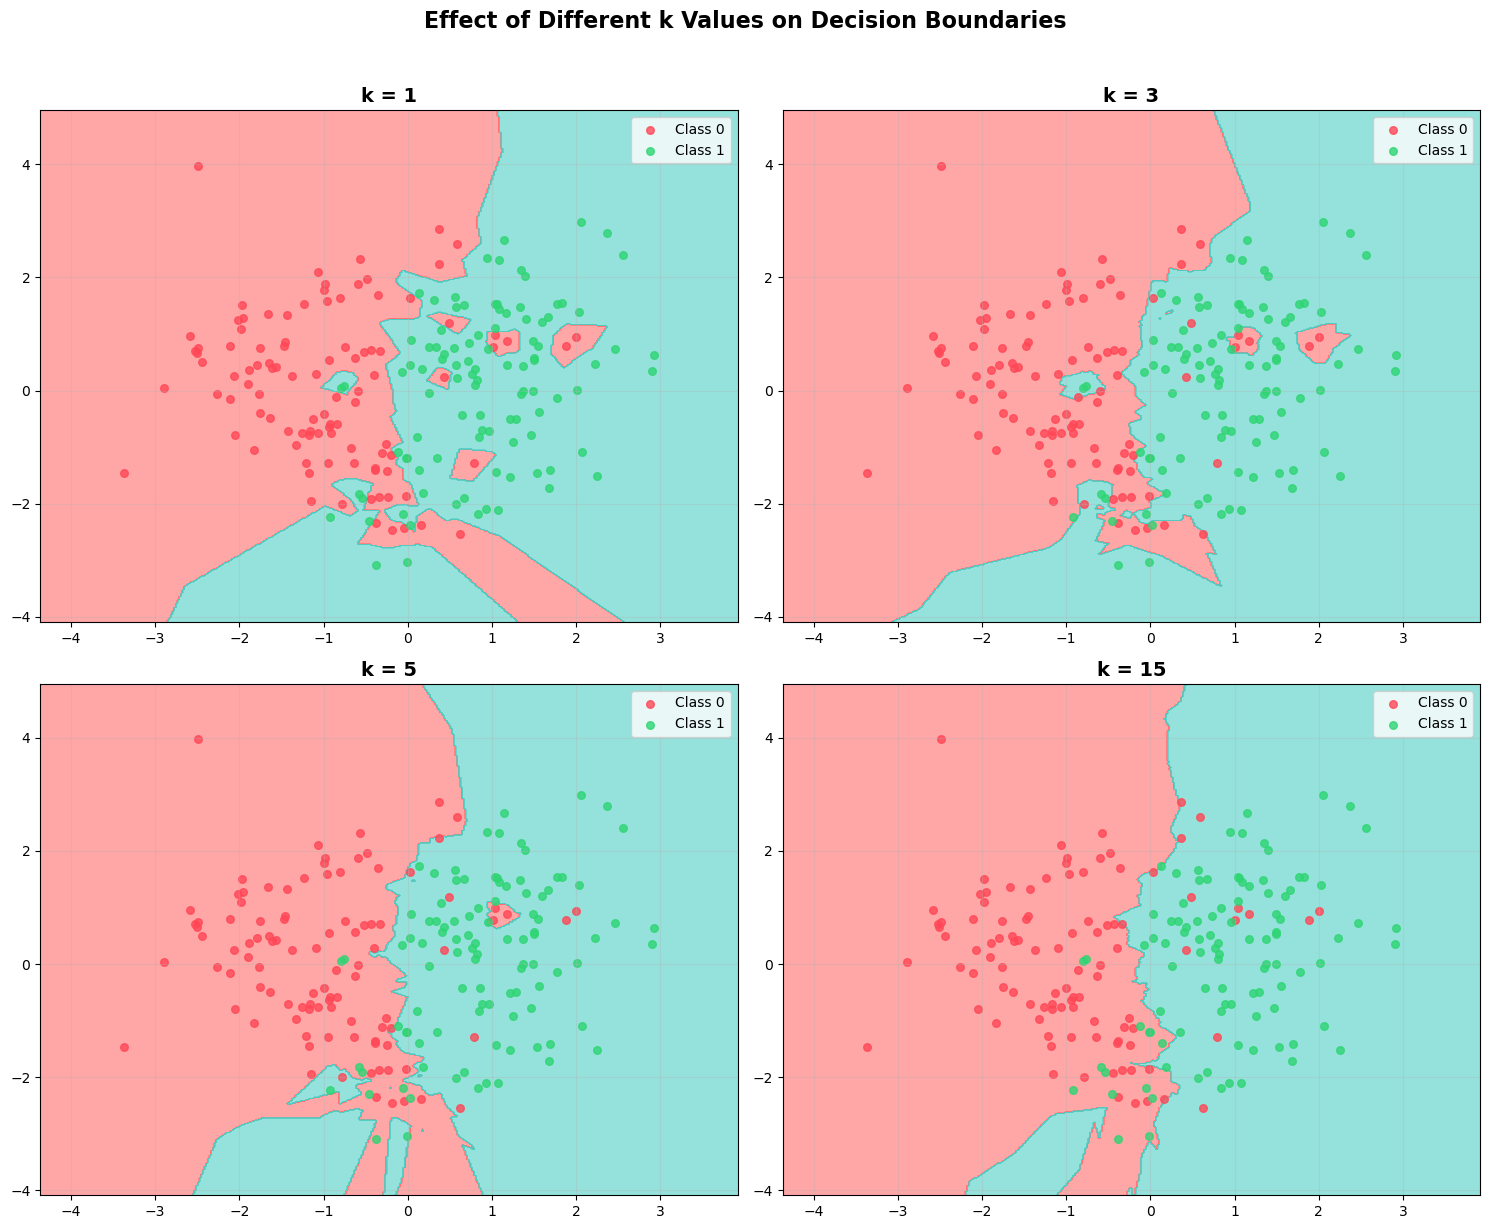

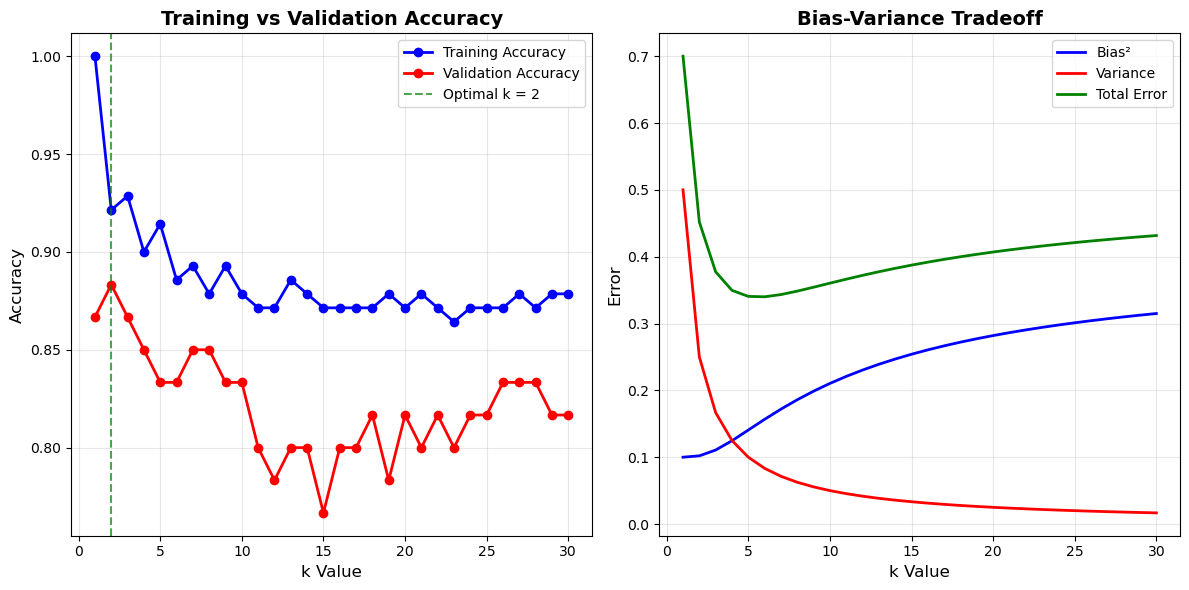

Optimal k value: 2
Best validation accuracy: 0.883


In [3]:
# Visualize the effect of different k values
k_values = [1, 3, 5, 15]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Create a more complex dataset
X_complex, y_complex = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                          n_informative=2, n_clusters_per_class=2, 
                                          random_state=42)

# Create mesh for plotting decision boundaries
h = 0.02
x_min, x_max = X_complex[:, 0].min() - 1, X_complex[:, 0].max() + 1
y_min, y_max = X_complex[:, 1].min() - 1, X_complex[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

colors_map = ListedColormap(['#FF6B6B', '#4ECDC4'])
colors_scatter = ['#FF4757', '#2ED573']

for i, k in enumerate(k_values):
    # Fit k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_complex, y_complex)
    
    # Predict on mesh
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    axes[i].contourf(xx, yy, Z, alpha=0.6, cmap=colors_map)
    
    # Plot data points
    for class_idx in range(2):
        mask = y_complex == class_idx
        axes[i].scatter(X_complex[mask, 0], X_complex[mask, 1], 
                       c=colors_scatter[class_idx], s=30, alpha=0.8,
                       label=f'Class {class_idx}')
    
    axes[i].set_title(f'k = {k}', fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Effect of Different k Values on Decision Boundaries', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Analyze performance for different k values
k_range = range(1, 31)
train_scores = []
val_scores = []

X_train, X_val, y_train, y_val = train_test_split(X_complex, y_complex, 
                                                  test_size=0.3, random_state=42)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_score = knn.score(X_train, y_train)
    val_score = knn.score(X_val, y_val)
    
    train_scores.append(train_score)
    val_scores.append(val_score)

# Plot training vs validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, train_scores, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(k_range, val_scores, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
plt.xlabel('k Value', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Find optimal k
optimal_k = k_range[np.argmax(val_scores)]
plt.axvline(x=optimal_k, color='green', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()

# Plot the bias-variance tradeoff concept
plt.subplot(1, 2, 2)
complexity = 1 / np.array(k_range)  # As k increases, complexity decreases
bias = 0.1 + 0.3 * np.exp(-complexity * 10)  # Simplified bias curve
variance = 0.5 * complexity  # Simplified variance curve
total_error = bias + variance + 0.1  # Add some irreducible error

plt.plot(k_range, bias, 'b-', label='Bias²', linewidth=2)
plt.plot(k_range, variance, 'r-', label='Variance', linewidth=2)
plt.plot(k_range, total_error, 'g-', label='Total Error', linewidth=2)
plt.xlabel('k Value', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Bias-Variance Tradeoff', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Optimal k value: {optimal_k}")
print(f"Best validation accuracy: {max(val_scores):.3f}")

## 3. Distance Metrics: How to Measure "Closeness"

The choice of distance metric significantly affects k-NN performance:

### Common Distance Metrics:

1. **Euclidean Distance** (L2): √[(x₁-x₂)² + (y₁-y₂)²]
   - Most common, works well for continuous features
   - Sensitive to feature scales

2. **Manhattan Distance** (L1): |x₁-x₂| + |y₁-y₂|
   - Less sensitive to outliers
   - Good for high-dimensional data

3. **Minkowski Distance**: Generalization of Euclidean and Manhattan
   - p=1: Manhattan, p=2: Euclidean

4. **Cosine Distance**: Measures angle between vectors
   - Good for text classification and high-dimensional sparse data

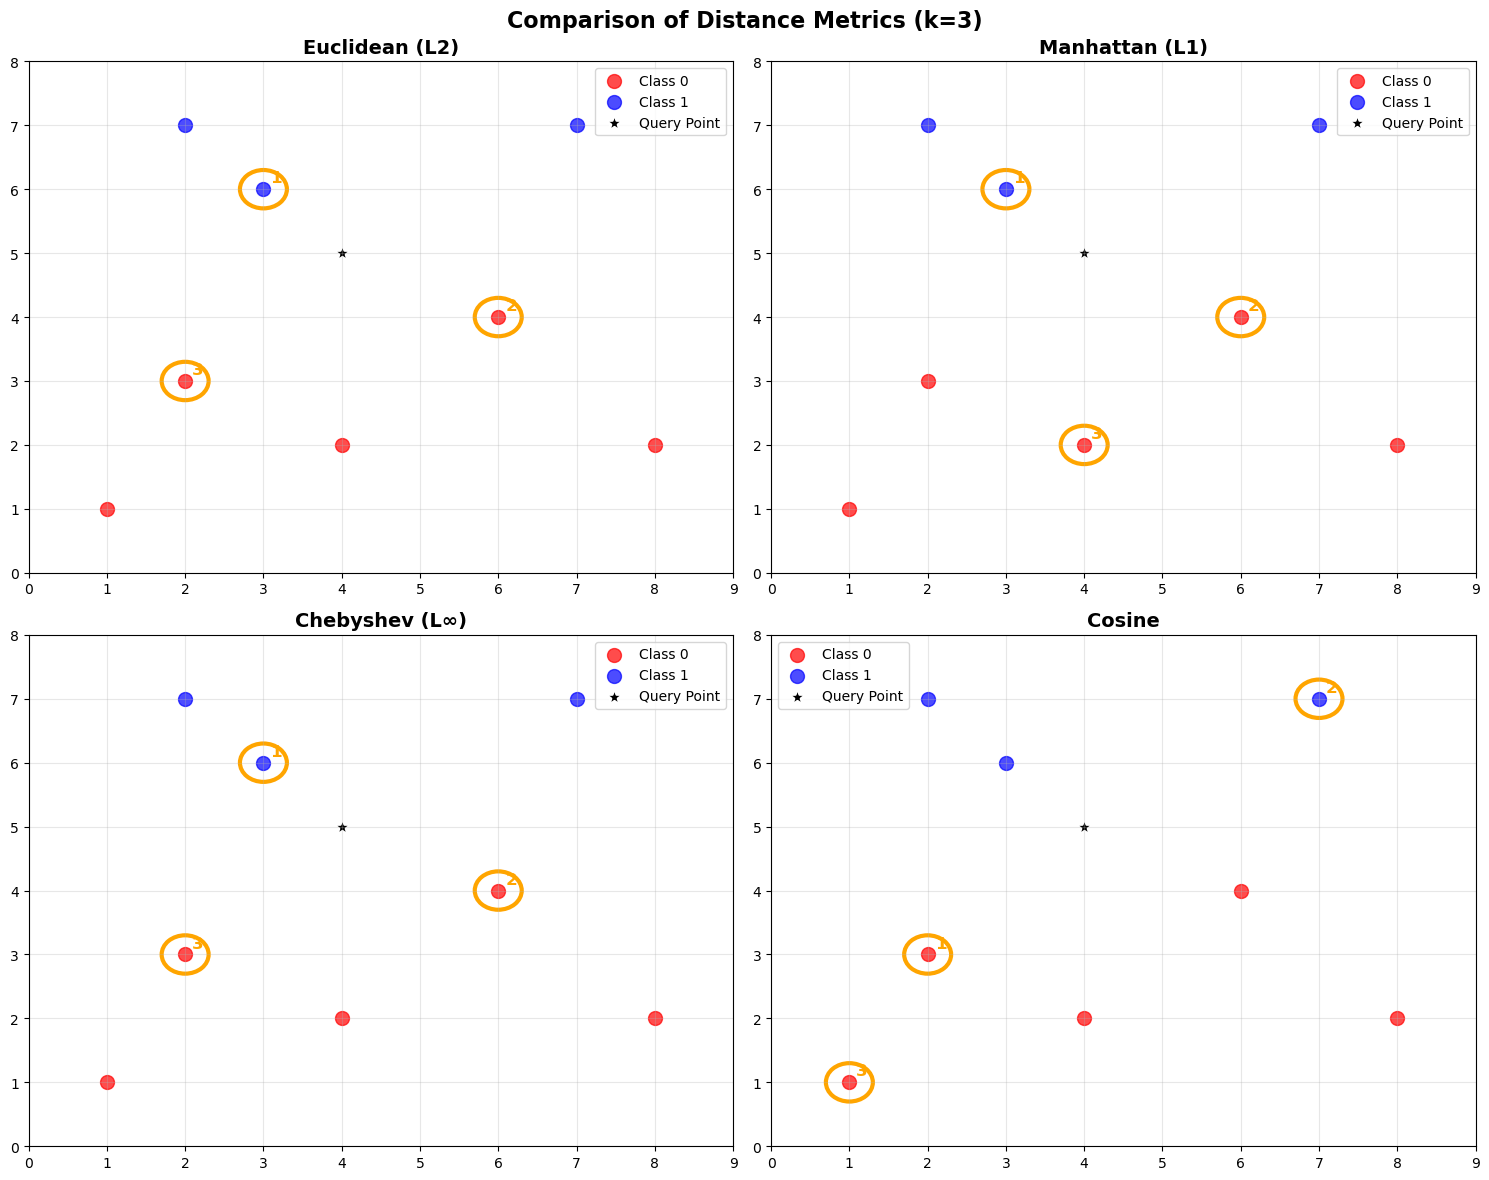

Effect of Feature Scaling on Distance Calculation
Original data (different scales):
Points: [[  1.  100. ]
 [  2.  150. ]
 [  1.5 120. ]
 [ 10.  200. ]]
Query: [  2 130]

Distances without scaling: [30.01666204 20.         10.0124922  70.45565982]
Nearest neighbor index: 2

Distances with scaling: [0.84113262 0.53097865 0.29794344 2.85217239]
Nearest neighbor index: 2


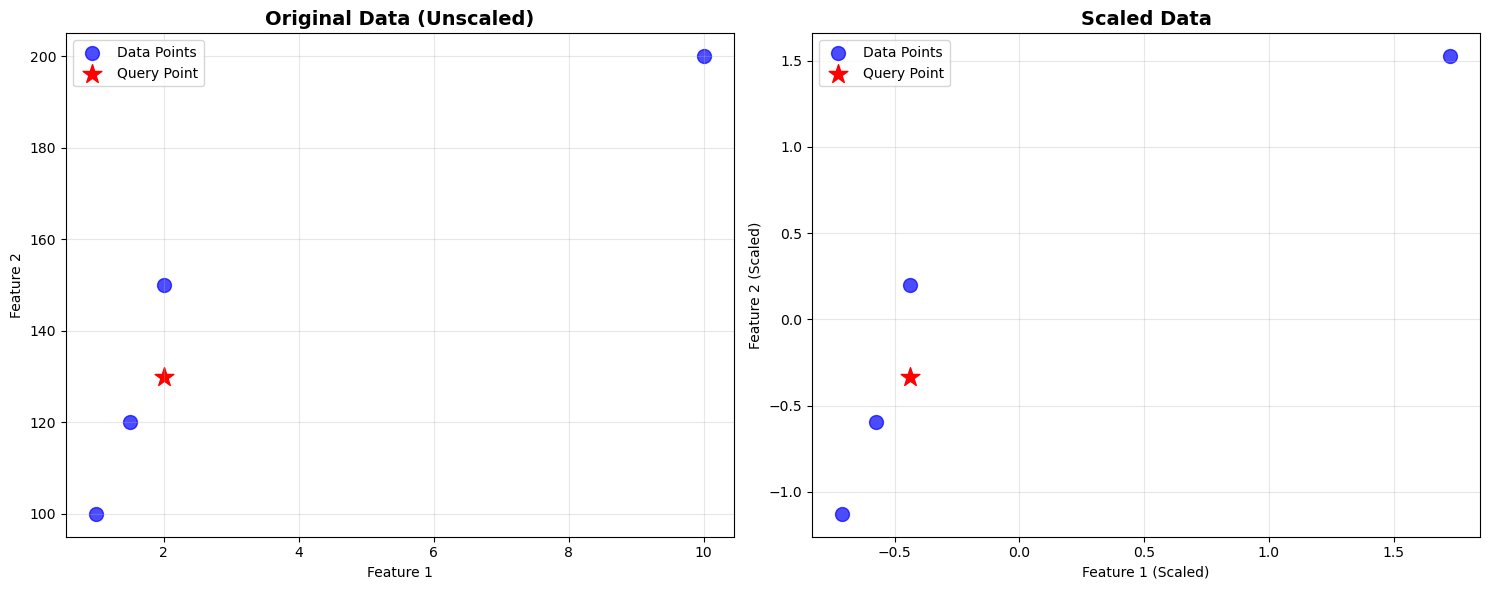

In [4]:
# Visualize different distance metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Create a simple dataset
X_dist = np.array([[2, 3], [4, 2], [3, 6], [6, 4], [7, 7], [1, 1], [8, 2], [2, 7]])
y_dist = np.array([0, 0, 1, 0, 1, 0, 0, 1])
query_point = np.array([4, 5])

distance_metrics = ['euclidean', 'manhattan', 'chebyshev', 'cosine']
metric_names = ['Euclidean (L2)', 'Manhattan (L1)', 'Chebyshev (L∞)', 'Cosine']

colors = ['red', 'blue']
for idx, (metric, name) in enumerate(zip(distance_metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    # Plot data points
    for class_idx in range(2):
        mask = y_dist == class_idx
        ax.scatter(X_dist[mask, 0], X_dist[mask, 1], 
                  c=colors[class_idx], s=100, alpha=0.7, 
                  label=f'Class {class_idx}')
    
    # Plot query point
    ax.scatter(query_point[0], query_point[1], c='black', s=200, 
              marker='*', label='Query Point', edgecolors='white', linewidth=2)
    
    # Calculate distances
    if metric == 'cosine':
        from sklearn.metrics.pairwise import cosine_distances
        distances = cosine_distances([query_point], X_dist)[0]
    else:
        knn_temp = KNeighborsClassifier(n_neighbors=3, metric=metric)
        knn_temp.fit(X_dist, y_dist)
        distances, indices = knn_temp.kneighbors([query_point])
        distances = distances[0]
        
    # Find k=3 nearest neighbors
    if metric != 'cosine':
        knn_temp = KNeighborsClassifier(n_neighbors=3, metric=metric)
        knn_temp.fit(X_dist, y_dist)
        distances, indices = knn_temp.kneighbors([query_point])
        nearest_indices = indices[0]
    else:
        nearest_indices = np.argsort(distances)[:3]
    
    # Highlight nearest neighbors
    for i, idx in enumerate(nearest_indices):
        circle = plt.Circle((X_dist[idx, 0], X_dist[idx, 1]), 0.3, 
                           fill=False, color='orange', linewidth=3)
        ax.add_patch(circle)
        ax.annotate(f'{i+1}', (X_dist[idx, 0], X_dist[idx, 1]), 
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=12, fontweight='bold', color='orange')
    
    ax.set_title(f'{name}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 8)

plt.suptitle('Comparison of Distance Metrics (k=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Demonstrate the effect of feature scaling on Euclidean distance
print("Effect of Feature Scaling on Distance Calculation")
print("="*50)

# Create a dataset with different scales
X_scale = np.array([[1, 100], [2, 150], [1.5, 120], [10, 200]])
query = np.array([[2, 130]])

print("Original data (different scales):")
print("Points:", X_scale)
print("Query:", query[0])

# Calculate Euclidean distances without scaling
distances_unscaled = np.sqrt(np.sum((X_scale - query) ** 2, axis=1))
print(f"\nDistances without scaling: {distances_unscaled}")
print(f"Nearest neighbor index: {np.argmin(distances_unscaled)}")

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scale)
query_scaled = scaler.transform(query)

# Calculate distances with scaling
distances_scaled = np.sqrt(np.sum((X_scaled - query_scaled) ** 2, axis=1))
print(f"\nDistances with scaling: {distances_scaled}")
print(f"Nearest neighbor index: {np.argmin(distances_scaled)}")

# Visualize the scaling effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Unscaled data
ax1.scatter(X_scale[:, 0], X_scale[:, 1], c='blue', s=100, alpha=0.7, label='Data Points')
ax1.scatter(query[0, 0], query[0, 1], c='red', s=200, marker='*', label='Query Point')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Original Data (Unscaled)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scaled data
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', s=100, alpha=0.7, label='Data Points')
ax2.scatter(query_scaled[0, 0], query_scaled[0, 1], c='red', s=200, marker='*', label='Query Point')
ax2.set_xlabel('Feature 1 (Scaled)')
ax2.set_ylabel('Feature 2 (Scaled)')
ax2.set_title('Scaled Data', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. k-NN for Regression

k-NN can also be used for regression tasks where we predict continuous values instead of classes.

### Key Differences from Classification:
- **Output**: Average (or weighted average) of k nearest neighbors' values
- **Evaluation**: Use MSE, MAE, R² instead of accuracy
- **Applications**: Price prediction, weather forecasting, stock prices

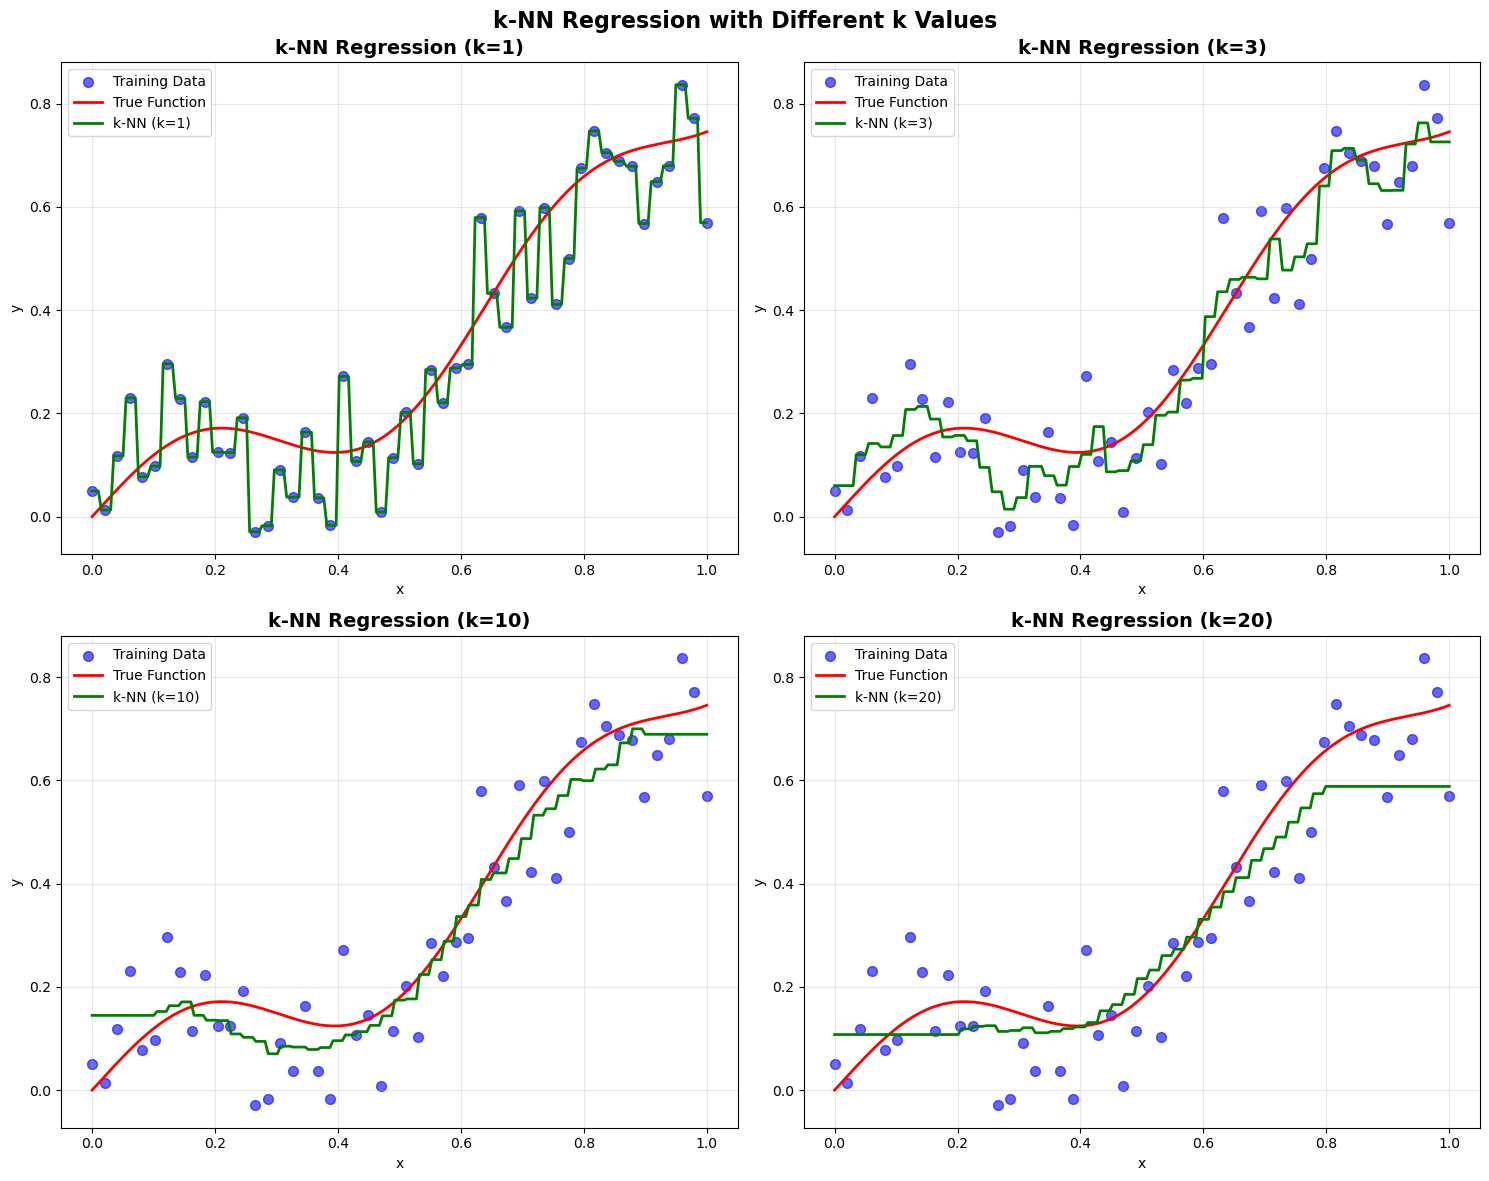

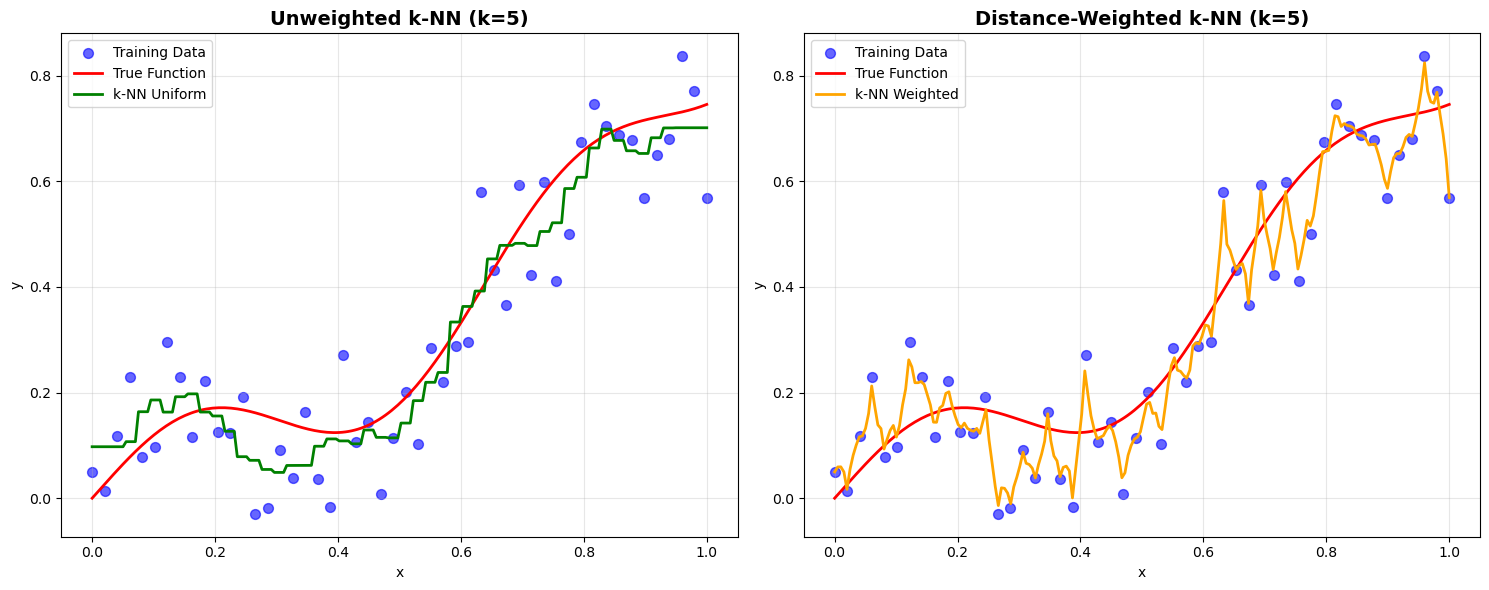

Regression Performance Comparison

Uniform k-NN:
  MSE: 0.0025
  MAE: 0.0425
  R²:  0.9576

Weighted k-NN:
  MSE: 0.0045
  MAE: 0.0529
  R²:  0.9249


In [5]:
# Demonstrate k-NN Regression
np.random.seed(42)

# Generate synthetic regression data
def true_function(x):
    return 0.5 * x**2 + 0.3 * x + 0.1 * np.sin(10 * x)

X_reg = np.linspace(0, 1, 50).reshape(-1, 1)
y_reg = true_function(X_reg.ravel()) + np.random.normal(0, 0.1, 50)

# Create test points for smooth curve
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = true_function(X_test.ravel())

# Compare different k values for regression
k_values_reg = [1, 3, 10, 20]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, k in enumerate(k_values_reg):
    # Fit k-NN regressor
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X_reg, y_reg)
    
    # Predict on test set
    y_pred = knn_reg.predict(X_test)
    
    # Plot results
    axes[i].scatter(X_reg, y_reg, c='blue', alpha=0.6, s=50, label='Training Data')
    axes[i].plot(X_test, y_true, 'r-', linewidth=2, label='True Function')
    axes[i].plot(X_test, y_pred, 'g-', linewidth=2, label=f'k-NN (k={k})')
    axes[i].set_title(f'k-NN Regression (k={k})', fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')

plt.suptitle('k-NN Regression with Different k Values', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Demonstrate weighted vs unweighted k-NN regression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Unweighted k-NN
knn_uniform = KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn_uniform.fit(X_reg, y_reg)
y_pred_uniform = knn_uniform.predict(X_test)

# Weighted k-NN (distance-based weights)
knn_weighted = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_weighted.fit(X_reg, y_reg)
y_pred_weighted = knn_weighted.predict(X_test)

# Plot unweighted
ax1.scatter(X_reg, y_reg, c='blue', alpha=0.6, s=50, label='Training Data')
ax1.plot(X_test, y_true, 'r-', linewidth=2, label='True Function')
ax1.plot(X_test, y_pred_uniform, 'g-', linewidth=2, label='k-NN Uniform')
ax1.set_title('Unweighted k-NN (k=5)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot weighted
ax2.scatter(X_reg, y_reg, c='blue', alpha=0.6, s=50, label='Training Data')
ax2.plot(X_test, y_true, 'r-', linewidth=2, label='True Function')
ax2.plot(X_test, y_pred_weighted, 'orange', linewidth=2, label='k-NN Weighted')
ax2.set_title('Distance-Weighted k-NN (k=5)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()

# Calculate and display metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Regression Performance Comparison")
print("="*40)

for name, model in [('Uniform k-NN', knn_uniform), ('Weighted k-NN', knn_weighted)]:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²:  {r2:.4f}")

## 5. Real-World Application: Iris Flower Classification

Let's apply k-NN to the famous Iris dataset to classify flower species based on their measurements.

Iris Dataset Overview
Number of samples: 150
Number of features: 4
Classes: ['setosa' 'versicolor' 'virginica']

Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


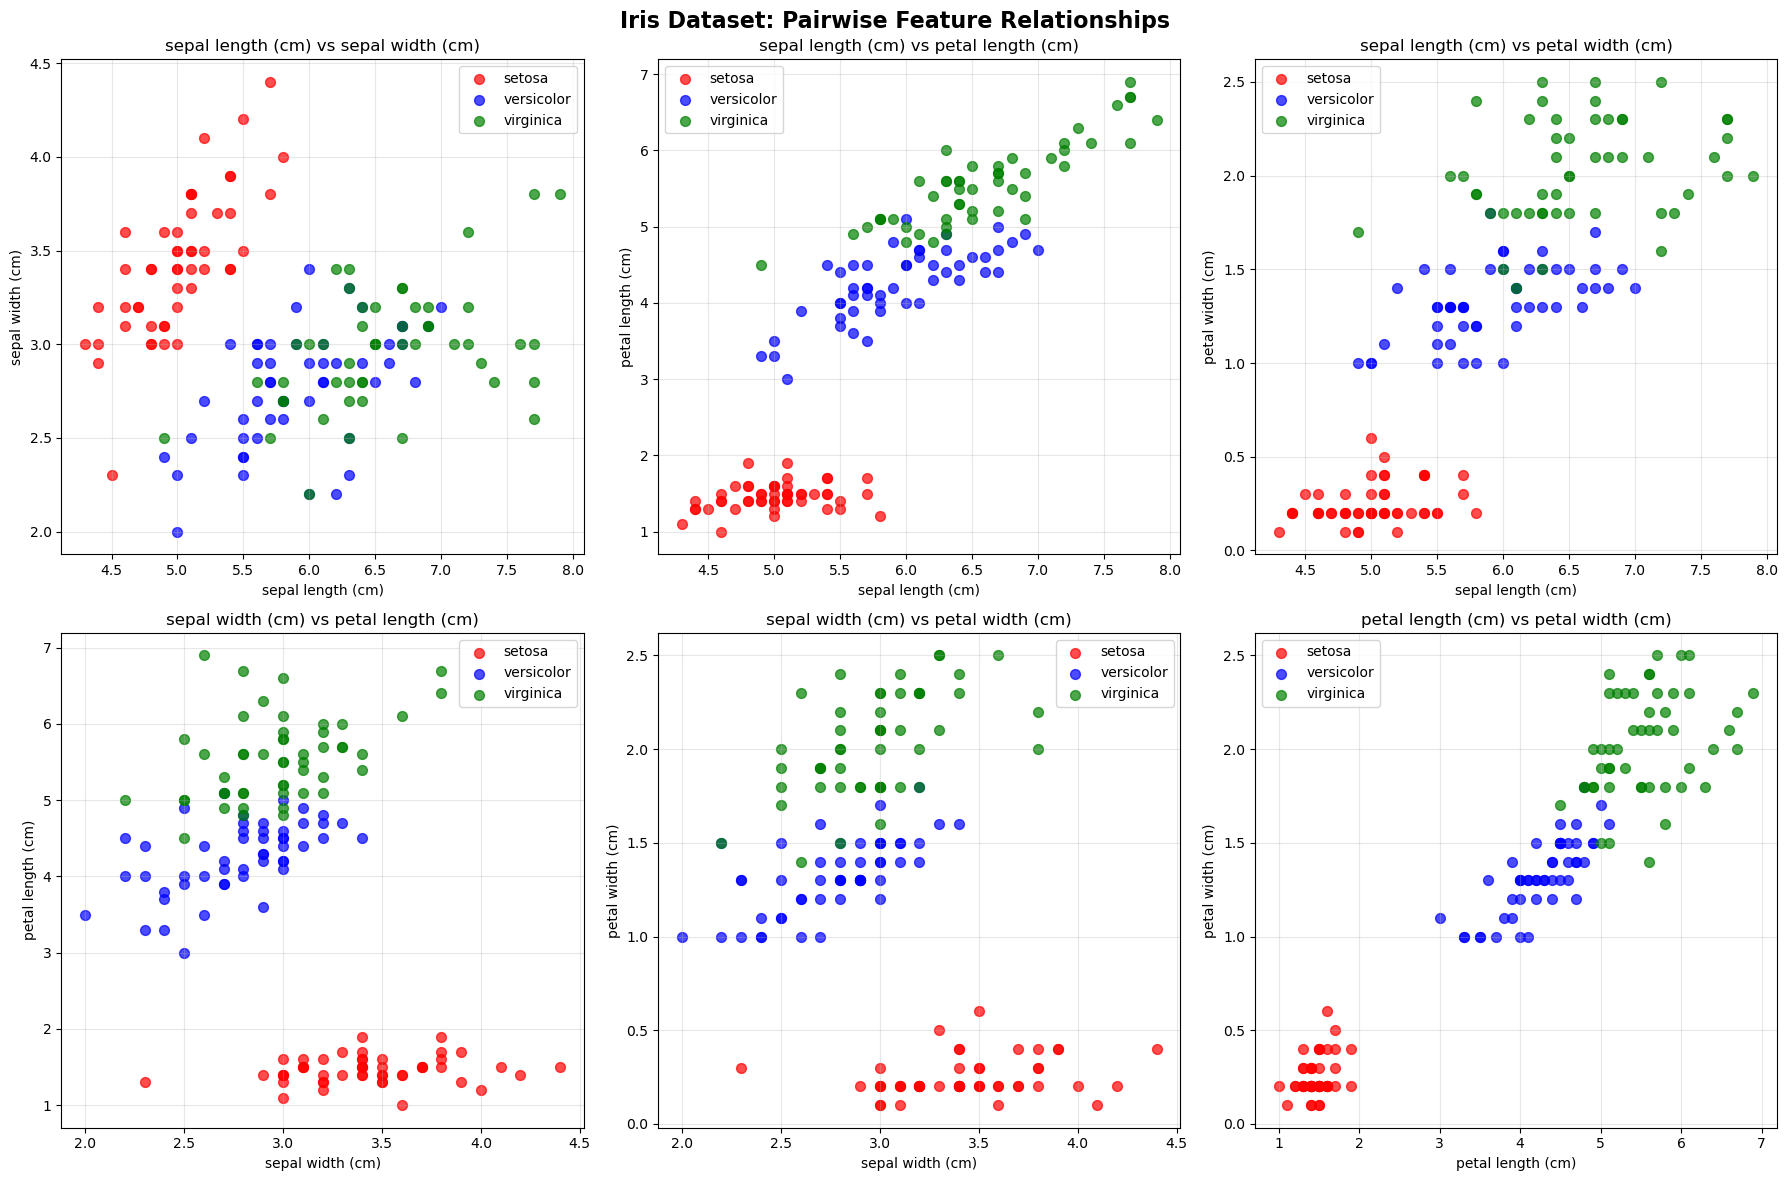

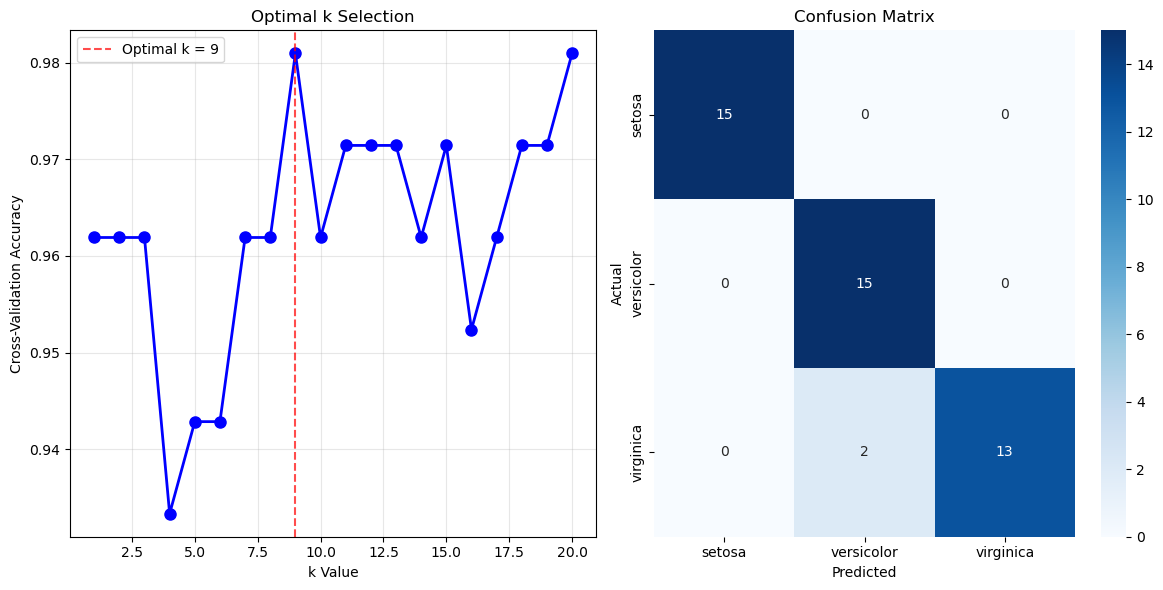


Optimal k value: 9
Cross-validation accuracy: 0.981
Test accuracy: 0.956

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


Prediction Example:
New flower measurements: [5.  3.  1.5 0.2]
Predicted species: setosa
Prediction probabilities:
  setosa: 1.000
  versicolor: 0.000
  virginica: 0.000


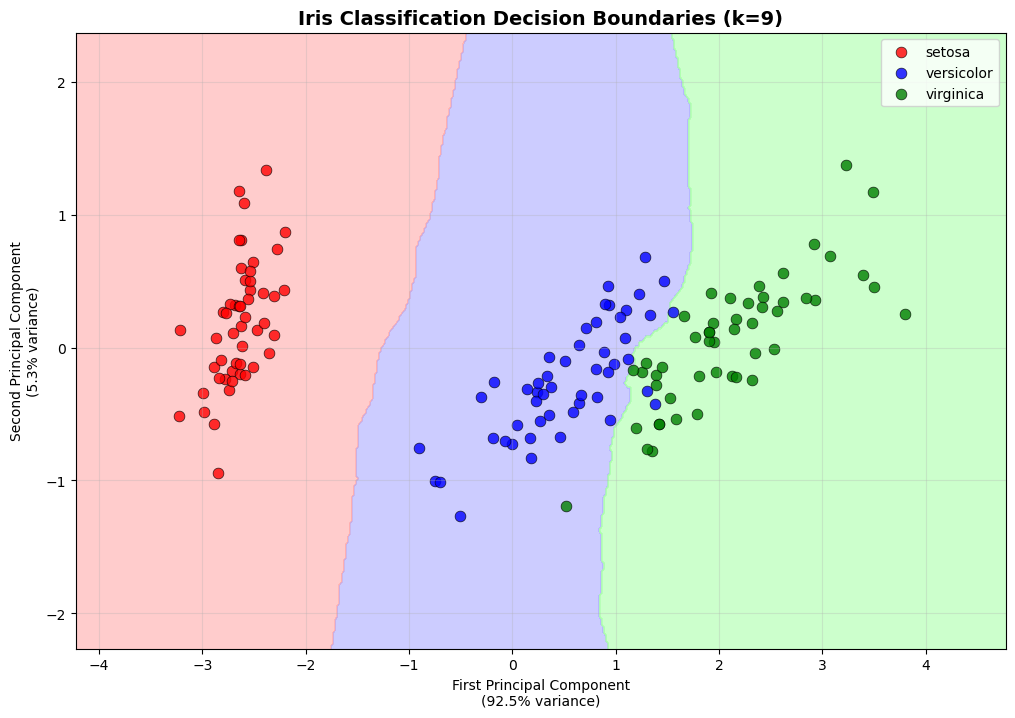


PCA explained variance ratio: [0.92461872 0.05306648]
Total variance explained: 0.978


In [6]:
# Load and explore the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create a DataFrame for easier manipulation
iris_df = pd.DataFrame(X_iris, columns=feature_names)
iris_df['species'] = [target_names[i] for i in y_iris]

print("Iris Dataset Overview")
print("="*30)
print(f"Number of samples: {len(iris_df)}")
print(f"Number of features: {len(feature_names)}")
print(f"Classes: {target_names}")
print(f"\nClass distribution:")
print(iris_df['species'].value_counts())

# Display first few rows
print("\nFirst 5 rows:")
print(iris_df.head())

# Visualize the dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Pairwise scatter plots
feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
colors = ['red', 'blue', 'green']

for idx, (i, j) in enumerate(feature_pairs):
    ax = axes[idx // 3, idx % 3]
    
    for class_idx in range(3):
        mask = y_iris == class_idx
        ax.scatter(X_iris[mask, i], X_iris[mask, j], 
                  c=colors[class_idx], alpha=0.7, s=50,
                  label=target_names[class_idx])
    
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f'{feature_names[i]} vs {feature_names[j]}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Iris Dataset: Pairwise Feature Relationships', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Train k-NN classifier and evaluate performance
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=y_iris)

# Find optimal k using cross-validation
k_range = range(1, 21)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot cross-validation scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, cv_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('k Value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Optimal k Selection')
plt.grid(True, alpha=0.3)

optimal_k = k_range[np.argmax(cv_scores)]
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()

# Train final model with optimal k
knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(X_train, y_train)

# Make predictions
y_pred = knn_final.predict(X_test)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\nOptimal k value: {optimal_k}")
print(f"Cross-validation accuracy: {max(cv_scores):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Demonstrate prediction on new data
print("\nPrediction Example:")
print("="*20)
new_flower = np.array([[5.0, 3.0, 1.5, 0.2]])  # Example measurements
prediction = knn_final.predict(new_flower)
probabilities = knn_final.predict_proba(new_flower)

print(f"New flower measurements: {new_flower[0]}")
print(f"Predicted species: {target_names[prediction[0]]}")
print("Prediction probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"  {target_names[i]}: {prob:.3f}")

# Visualize decision boundaries for 2D projection
# Use the two most informative features
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_iris)

# Train k-NN on 2D data
knn_2d = KNeighborsClassifier(n_neighbors=optimal_k)
knn_2d.fit(X_pca, y_iris)

# Create mesh for decision boundary
h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on mesh
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.figure(figsize=(12, 8))
colors_map = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
plt.contourf(xx, yy, Z, alpha=0.6, cmap=colors_map)

# Plot data points
for class_idx in range(3):
    mask = y_iris == class_idx
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[class_idx], s=60, alpha=0.8,
               label=target_names[class_idx], edgecolors='black', linewidth=0.5)

plt.xlabel(f'First Principal Component\n({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component\n({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Iris Classification Decision Boundaries (k={optimal_k})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

## 6. Advantages and Disadvantages of k-NN

### ✅ Advantages:

1. **Simple and Intuitive**: Easy to understand and implement
2. **No Training Period**: Just stores the data (lazy learning)
3. **Versatile**: Works for both classification and regression
4. **Non-parametric**: Makes no assumptions about data distribution
5. **Naturally Handles Multi-class Problems**: No need for special techniques
6. **Local Decision Making**: Can capture complex patterns locally

### ❌ Disadvantages:

1. **Computational Cost**: Expensive at prediction time (O(n) for each prediction)
2. **Memory Requirements**: Must store all training data
3. **Sensitive to Irrelevant Features**: All features are considered equally
4. **Curse of Dimensionality**: Performance degrades in high-dimensional spaces
5. **Sensitive to Feature Scales**: Requires normalization/standardization
6. **Sensitive to Local Structure**: Can be affected by noisy data
7. **Choosing k**: Optimal k selection can be challenging

Demonstrating the Curse of Dimensionality


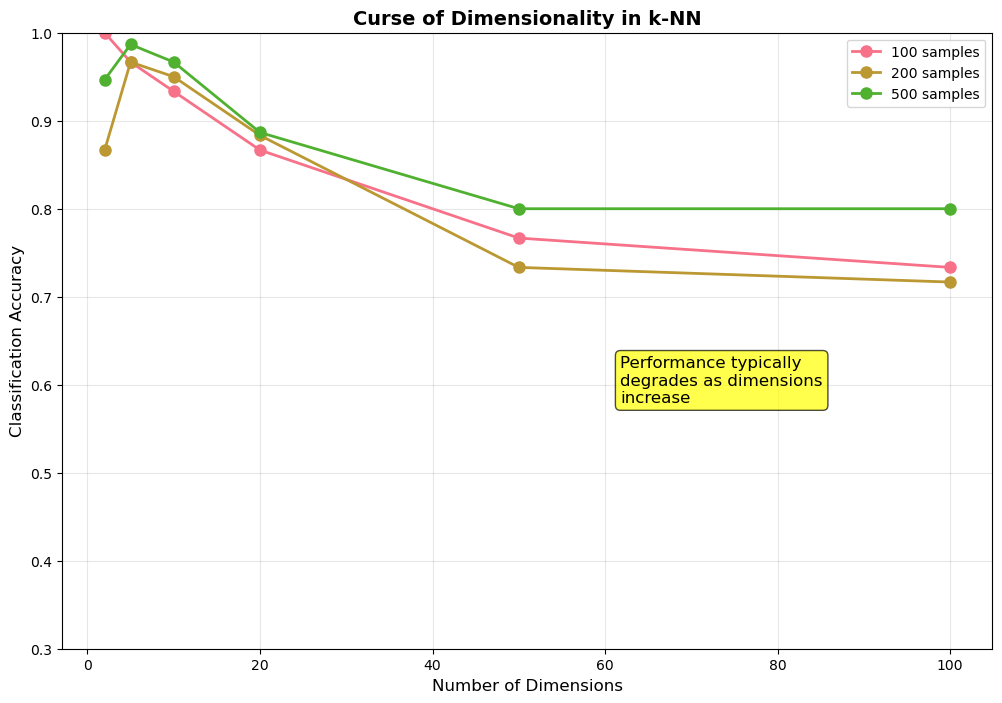


Computational Complexity Analysis


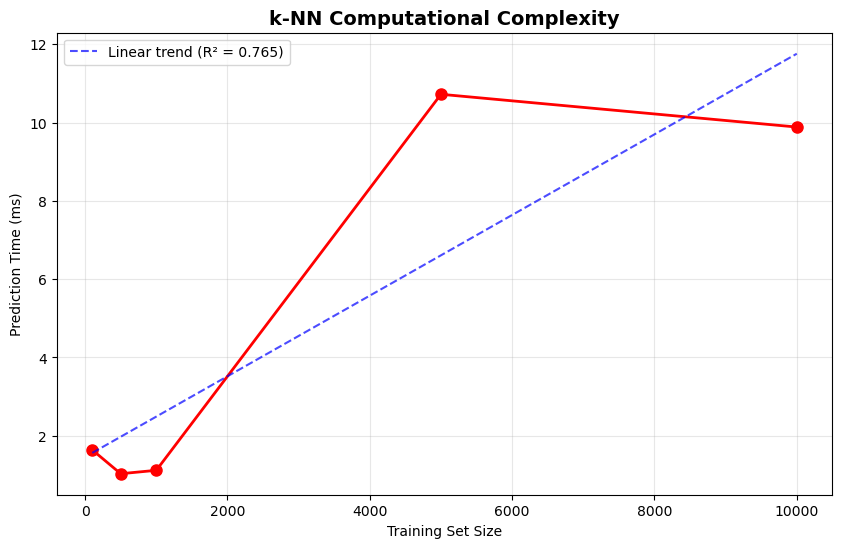

Training Set Size vs Prediction Time:
    100 samples:   1.64 ms
    500 samples:   1.03 ms
   1000 samples:   1.12 ms
   5000 samples:  10.72 ms
  10000 samples:   9.88 ms

Linear correlation (R²): 0.765
Note: Prediction time scales linearly with training set size


In [7]:
# Demonstrate the Curse of Dimensionality
print("Demonstrating the Curse of Dimensionality")
print("="*45)

# Generate datasets with increasing dimensions
dimensions = [2, 5, 10, 20, 50, 100]
sample_sizes = [100, 200, 500]
k_value = 5

results = []

for n_samples in sample_sizes:
    accuracies = []
    
    for n_dims in dimensions:
        # Generate synthetic dataset
        X, y = make_classification(n_samples=n_samples, n_features=n_dims, 
                                  n_informative=min(n_dims, 10), n_redundant=0, 
                                  n_clusters_per_class=1, random_state=42)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=42)
        
        # Standardize features (important for k-NN)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train k-NN classifier
        knn = KNeighborsClassifier(n_neighbors=k_value)
        knn.fit(X_train_scaled, y_train)
        
        # Calculate accuracy
        accuracy = knn.score(X_test_scaled, y_test)
        accuracies.append(accuracy)
    
    results.append(accuracies)

# Plot the results
plt.figure(figsize=(12, 8))

for i, n_samples in enumerate(sample_sizes):
    plt.plot(dimensions, results[i], 'o-', linewidth=2, markersize=8, 
             label=f'{n_samples} samples')

plt.xlabel('Number of Dimensions', fontsize=12)
plt.ylabel('Classification Accuracy', fontsize=12)
plt.title('Curse of Dimensionality in k-NN', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.3, 1.0)

# Add explanation text
plt.text(0.6, 0.4, 'Performance typically\ndegrades as dimensions\nincrease', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.show()

# Demonstrate computational complexity
print("\nComputational Complexity Analysis")
print("="*35)

sample_sizes = [100, 500, 1000, 5000, 10000]
prediction_times = []

# Create a fixed test dataset
X_fixed, y_fixed = make_classification(n_samples=1000, n_features=10, random_state=42)
X_test_fixed = X_fixed[:100]  # 100 test points

for n_samples in sample_sizes:
    # Create training set of varying size
    X_train, y_train = make_classification(n_samples=n_samples, n_features=10, random_state=42)
    
    # Fit k-NN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # Measure prediction time
    import time
    start_time = time.time()
    predictions = knn.predict(X_test_fixed)
    end_time = time.time()
    
    prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds
    prediction_times.append(prediction_time)

# Plot computational complexity
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, prediction_times, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Training Set Size')
plt.ylabel('Prediction Time (ms)')
plt.title('k-NN Computational Complexity', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Fit and plot linear trend
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(sample_sizes, prediction_times)
line = slope * np.array(sample_sizes) + intercept
plt.plot(sample_sizes, line, 'b--', alpha=0.7, label=f'Linear trend (R² = {r_value**2:.3f})')
plt.legend()
plt.show()

print("Training Set Size vs Prediction Time:")
for size, time in zip(sample_sizes, prediction_times):
    print(f"  {size:5d} samples: {time:6.2f} ms")

print(f"\nLinear correlation (R²): {r_value**2:.3f}")
print("Note: Prediction time scales linearly with training set size")

## 7. Hyperparameter Tuning and Best Practices

### Key Hyperparameters:
1. **n_neighbors (k)**: Number of neighbors to consider
2. **weights**: 'uniform' or 'distance' or custom function
3. **metric**: Distance metric ('euclidean', 'manhattan', 'minkowski', etc.)
4. **algorithm**: Method for finding neighbors ('auto', 'ball_tree', 'kd_tree', 'brute')

### Best Practices:
1. **Always scale/normalize features** when using distance-based metrics
2. **Use cross-validation** to select optimal k
3. **Consider the square root of sample size** as starting point for k
4. **Remove irrelevant features** to avoid curse of dimensionality
5. **Use appropriate distance metrics** for your data type
6. **Consider computational costs** for large datasets

Comprehensive k-NN Hyperparameter Tuning
Performing Grid Search...
Fitting 5 folds for each of 168 candidates, totalling 840 fits

Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score: 0.9757
Test accuracy: 0.9630


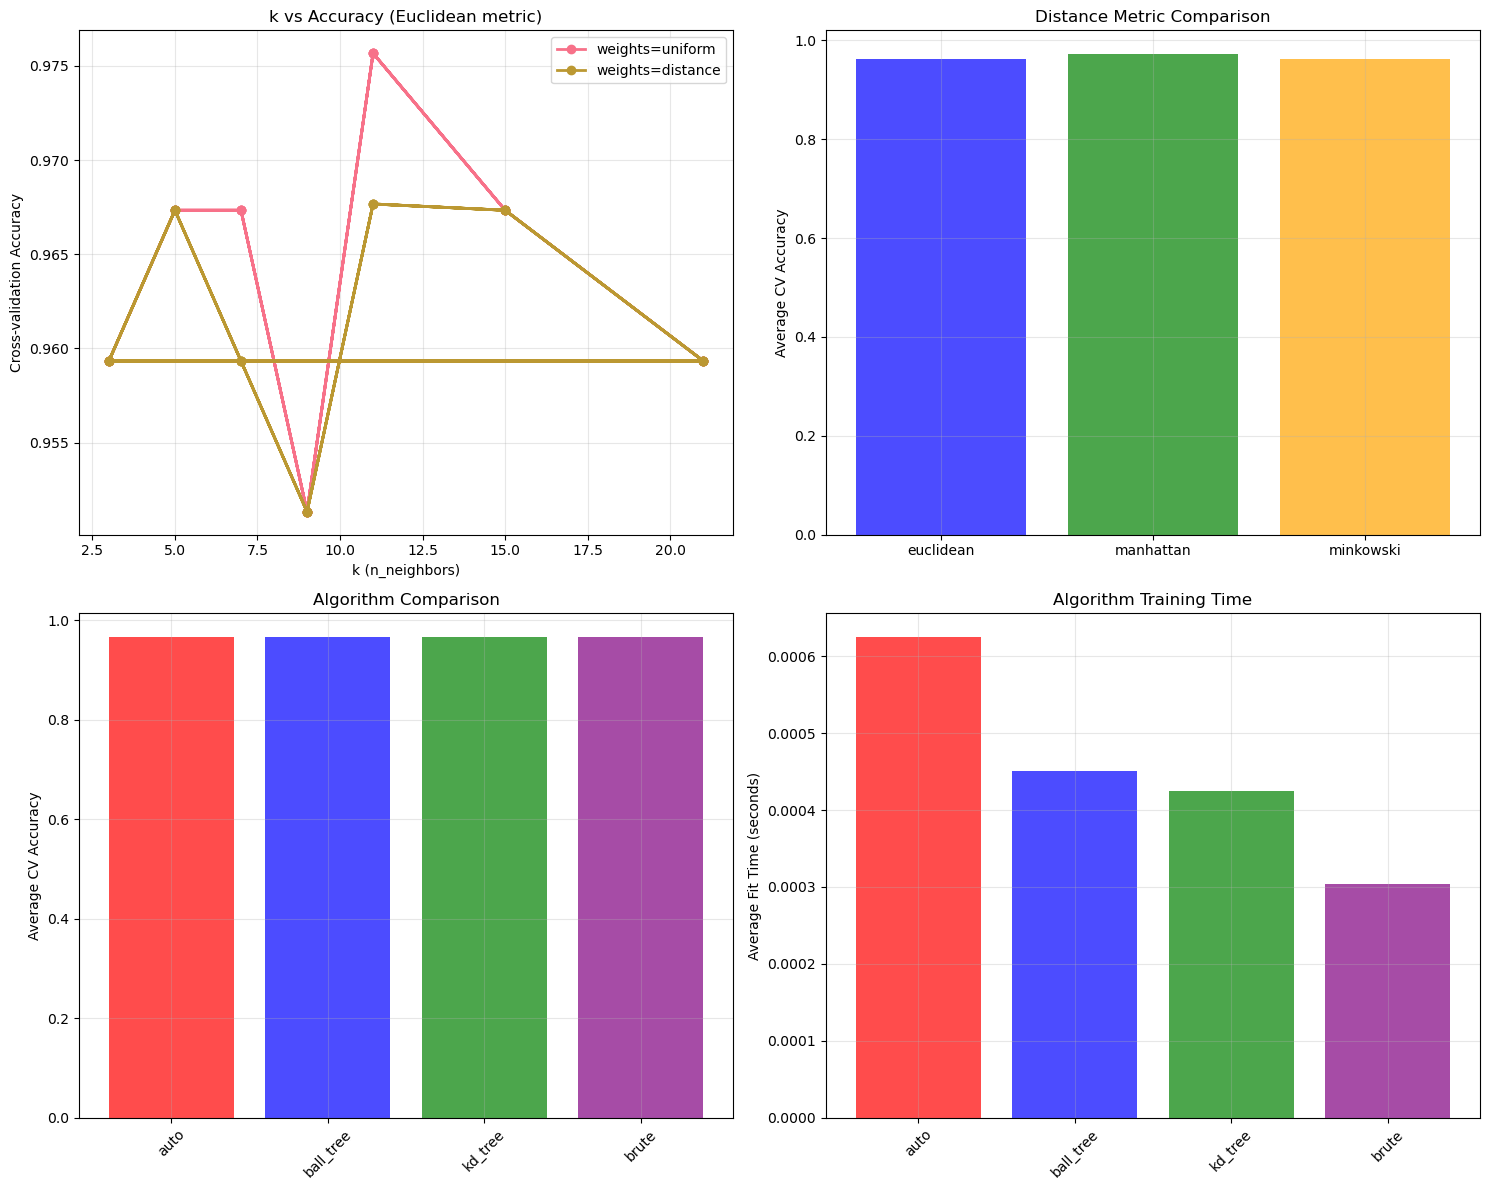


Feature Importance Analysis


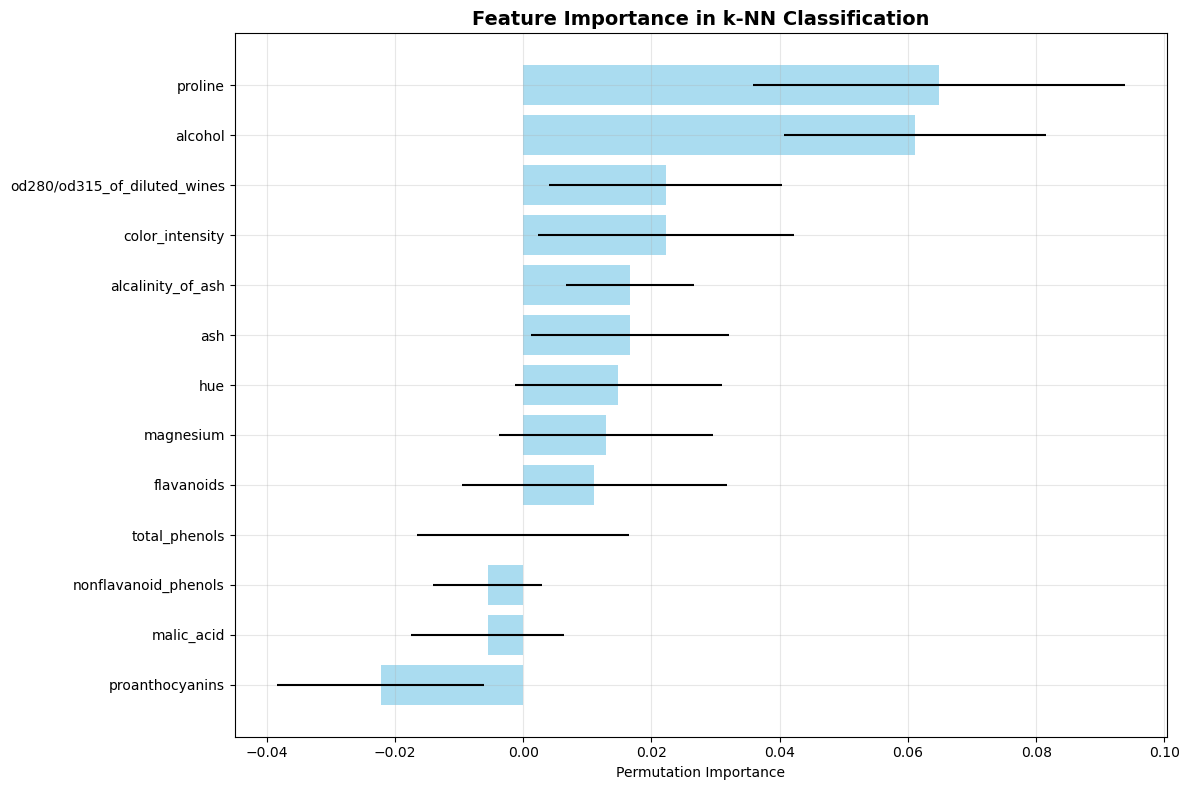

Top 5 most important features:
  alcalinity_of_ash: 0.0167 ± 0.0100
  color_intensity: 0.0222 ± 0.0199
  od280/od315_of_diluted_wines: 0.0222 ± 0.0181
  alcohol: 0.0611 ± 0.0204
  proline: 0.0648 ± 0.0290

Feature Selection Impact
Accuracy with all features: 0.9630
Accuracy with top 5 features: 0.9259
Feature reduction: 13 → 5 features
Selected features: ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']


In [8]:
# Comprehensive Hyperparameter Tuning Example
print("Comprehensive k-NN Hyperparameter Tuning")
print("="*42)

# Load wine dataset for a more complex example
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=y_wine)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform grid search
print("Performing Grid Search...")
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, 
                          cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Test the best model
best_knn = grid_search.best_estimator_
test_score = best_knn.score(X_test_scaled, y_test)
print(f"Test accuracy: {test_score:.4f}")

# Visualize hyperparameter effects
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot k vs accuracy for different weights
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: k vs accuracy for different weights (euclidean metric)
euclidean_results = results_df[results_df['param_metric'] == 'euclidean']
for weight in ['uniform', 'distance']:
    weight_results = euclidean_results[euclidean_results['param_weights'] == weight]
    k_values = weight_results['param_n_neighbors'].values
    scores = weight_results['mean_test_score'].values
    axes[0, 0].plot(k_values, scores, 'o-', label=f'weights={weight}', linewidth=2, markersize=6)

axes[0, 0].set_xlabel('k (n_neighbors)')
axes[0, 0].set_ylabel('Cross-validation Accuracy')
axes[0, 0].set_title('k vs Accuracy (Euclidean metric)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Metric comparison
metrics = ['euclidean', 'manhattan', 'minkowski']
metric_scores = []
for metric in metrics:
    metric_results = results_df[results_df['param_metric'] == metric]
    avg_score = metric_results['mean_test_score'].mean()
    metric_scores.append(avg_score)

axes[0, 1].bar(metrics, metric_scores, color=['blue', 'green', 'orange'], alpha=0.7)
axes[0, 1].set_ylabel('Average CV Accuracy')
axes[0, 1].set_title('Distance Metric Comparison')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Algorithm comparison
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
algo_scores = []
algo_times = []
for algo in algorithms:
    algo_results = results_df[results_df['param_algorithm'] == algo]
    avg_score = algo_results['mean_test_score'].mean()
    avg_time = algo_results['mean_fit_time'].mean()
    algo_scores.append(avg_score)
    algo_times.append(avg_time)

axes[1, 0].bar(algorithms, algo_scores, color=['red', 'blue', 'green', 'purple'], alpha=0.7)
axes[1, 0].set_ylabel('Average CV Accuracy')
axes[1, 0].set_title('Algorithm Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Training time comparison
axes[1, 1].bar(algorithms, algo_times, color=['red', 'blue', 'green', 'purple'], alpha=0.7)
axes[1, 1].set_ylabel('Average Fit Time (seconds)')
axes[1, 1].set_title('Algorithm Training Time')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis using permutation importance
from sklearn.inspection import permutation_importance

print("\nFeature Importance Analysis")
print("="*28)

# Calculate permutation importance
perm_importance = permutation_importance(best_knn, X_test_scaled, y_test, 
                                       n_repeats=10, random_state=42)

# Create feature importance plot
feature_names = wine.feature_names
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})
importance_df = importance_df.sort_values('importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'], importance_df['importance'], 
         xerr=importance_df['std'], alpha=0.7, color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance in k-NN Classification', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 5 most important features
print("Top 5 most important features:")
top_features = importance_df.tail(5)
for idx, row in top_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f} ± {row['std']:.4f}")

# Compare performance with and without feature selection
from sklearn.feature_selection import SelectKBest, f_classif

print(f"\nFeature Selection Impact")
print("="*25)

# Select top k features
selector = SelectKBest(score_func=f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Train k-NN with selected features
knn_selected = KNeighborsClassifier(**grid_search.best_params_)
knn_selected.fit(X_train_selected, y_train)
selected_score = knn_selected.score(X_test_selected, y_test)

print(f"Accuracy with all features: {test_score:.4f}")
print(f"Accuracy with top 5 features: {selected_score:.4f}")
print(f"Feature reduction: {len(wine.feature_names)} → 5 features")

selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
print(f"Selected features: {selected_features}")

## 8. Summary and Key Takeaways

### 🎯 When to Use k-NN:
- **Small to medium datasets** (computational efficiency)
- **Non-linear decision boundaries** needed
- **Local patterns** are important
- **Multi-class classification** problems
- **Baseline model** for comparison
- **Interpretable results** required

### 🚫 When NOT to Use k-NN:
- **Large datasets** (computational cost)
- **High-dimensional data** (curse of dimensionality)
- **Real-time predictions** needed (slow inference)
- **Many irrelevant features** present
- **Limited memory** available

### 💡 Practical Tips:
1. **Always standardize/normalize** your features
2. **Start with k = √n** as a rule of thumb
3. **Use cross-validation** to tune hyperparameters
4. **Consider feature selection** for high-dimensional data
5. **Use distance weighting** for better performance
6. **Experiment with different distance metrics**
7. **Consider using approximate methods** (LSH, KD-trees) for large datasets

### 🔧 Implementation Checklist:
- [ ] Data preprocessing (scaling, handling missing values)
- [ ] Feature selection/engineering
- [ ] Train-validation-test split
- [ ] Hyperparameter tuning (k, weights, metric)
- [ ] Cross-validation for model selection
- [ ] Performance evaluation on test set
- [ ] Consider computational requirements for deployment

### 📚 Further Reading:
- Explore **approximate nearest neighbor** methods for large datasets
- Learn about **locality-sensitive hashing (LSH)**
- Study **ensemble methods** that combine k-NN with other algorithms
- Investigate **metric learning** for improving distance functions

## 9. Interactive Exercise 🎓

Try this hands-on exercise to test your understanding of k-NN!

🎓 Interactive k-NN Exercise
Your task: Create and tune a k-NN classifier for a new dataset!

Dataset Information:
- Number of samples: 300
- Number of features: 8
- Number of classes: 2
- Class distribution: [151 149]

📝 Exercise Steps:
1. Analyze the impact of feature scaling
2. Find the optimal k value
3. Compare different distance metrics
4. Evaluate your final model

Step 1: Analyzing Feature Scaling Impact
----------------------------------------
Accuracy without scaling: 0.9000
Accuracy with scaling:    0.9167
Improvement: 0.0167

Step 2: Finding Optimal k Value
-----------------------------------
Optimal k value: 5
Best CV accuracy: 0.9208


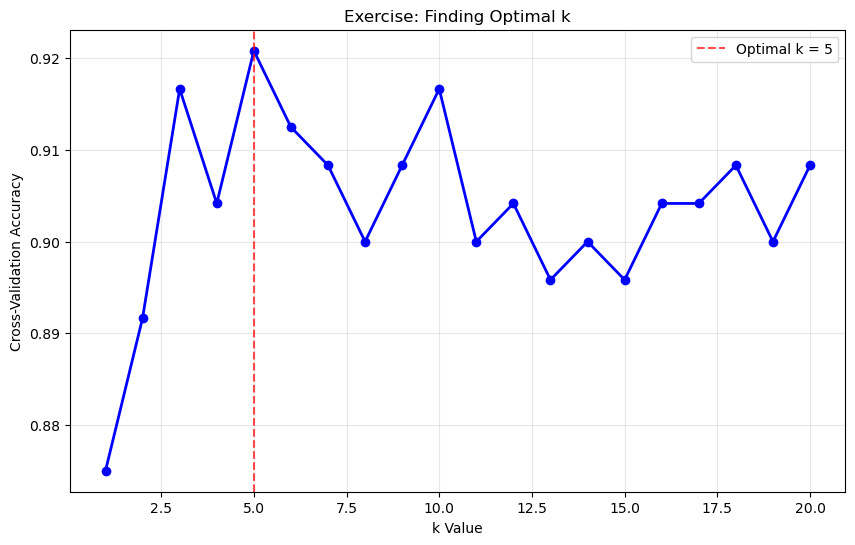

Step 3: Comparing Distance Metrics
--------------------------------------
euclidean : 0.9208 ± 0.0156
manhattan : 0.8958 ± 0.0264
chebyshev : 0.9250 ± 0.0212

Best metric: chebyshev

Step 4: Final Model Evaluation
--------------------------------
Final test accuracy: 0.9500

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



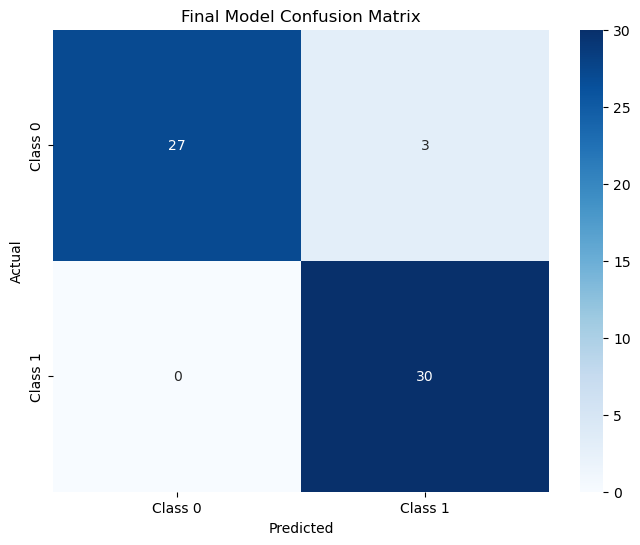

🤔 Challenge Questions:
1. What happens if you use k=1? Why might this be problematic?
2. How would performance change with more training data?
3. What if some features were categorical instead of numerical?
4. How could you handle imbalanced classes in this dataset?

Bonus Analysis - k=1 (Potential Overfitting):
Training accuracy (k=1): 1.0000
Test accuracy (k=1):     0.9000
Training accuracy (k=5):  0.9500
Test accuracy (k=5):      0.9500
✅ No significant overfitting detected.


In [9]:
# Interactive Exercise: Build Your Own k-NN Classifier
print("🎓 Interactive k-NN Exercise")
print("="*30)
print("Your task: Create and tune a k-NN classifier for a new dataset!")
print()

# Generate a challenging dataset
np.random.seed(123)  # Different seed for variety
X_exercise, y_exercise = make_classification(
    n_samples=300, 
    n_features=8, 
    n_informative=5, 
    n_redundant=2, 
    n_clusters_per_class=2, 
    class_sep=0.8,
    random_state=123
)

# Add some noise to make it more realistic
noise = np.random.normal(0, 0.1, X_exercise.shape)
X_exercise += noise

print("Dataset Information:")
print(f"- Number of samples: {X_exercise.shape[0]}")
print(f"- Number of features: {X_exercise.shape[1]}")
print(f"- Number of classes: {len(np.unique(y_exercise))}")
print(f"- Class distribution: {np.bincount(y_exercise)}")
print()

# Split the data
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(
    X_exercise, y_exercise, test_size=0.2, random_state=42, stratify=y_exercise
)

print("📝 Exercise Steps:")
print("1. Analyze the impact of feature scaling")
print("2. Find the optimal k value")
print("3. Compare different distance metrics")
print("4. Evaluate your final model")
print()

# Step 1: Feature Scaling Analysis
print("Step 1: Analyzing Feature Scaling Impact")
print("-" * 40)

# Without scaling
knn_unscaled = KNeighborsClassifier(n_neighbors=5)
knn_unscaled.fit(X_train_ex, y_train_ex)
accuracy_unscaled = knn_unscaled.score(X_test_ex, y_test_ex)

# With scaling
scaler_ex = StandardScaler()
X_train_scaled_ex = scaler_ex.fit_transform(X_train_ex)
X_test_scaled_ex = scaler_ex.transform(X_test_ex)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled_ex, y_train_ex)
accuracy_scaled = knn_scaled.score(X_test_scaled_ex, y_test_ex)

print(f"Accuracy without scaling: {accuracy_unscaled:.4f}")
print(f"Accuracy with scaling:    {accuracy_scaled:.4f}")
print(f"Improvement: {accuracy_scaled - accuracy_unscaled:.4f}")
print()

# Step 2: Find Optimal k
print("Step 2: Finding Optimal k Value")
print("-" * 35)

k_values_ex = range(1, 21)
cv_scores_ex = []

for k in k_values_ex:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled_ex, y_train_ex, cv=5)
    cv_scores_ex.append(scores.mean())

optimal_k_ex = k_values_ex[np.argmax(cv_scores_ex)]
print(f"Optimal k value: {optimal_k_ex}")
print(f"Best CV accuracy: {max(cv_scores_ex):.4f}")

# Plot k selection
plt.figure(figsize=(10, 6))
plt.plot(k_values_ex, cv_scores_ex, 'bo-', linewidth=2, markersize=6)
plt.axvline(x=optimal_k_ex, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k_ex}')
plt.xlabel('k Value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Exercise: Finding Optimal k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 3: Compare Distance Metrics
print("Step 3: Comparing Distance Metrics")
print("-" * 38)

metrics_ex = ['euclidean', 'manhattan', 'chebyshev']
metric_scores_ex = {}

for metric in metrics_ex:
    knn_metric = KNeighborsClassifier(n_neighbors=optimal_k_ex, metric=metric)
    scores = cross_val_score(knn_metric, X_train_scaled_ex, y_train_ex, cv=5)
    metric_scores_ex[metric] = scores.mean()
    print(f"{metric:10s}: {scores.mean():.4f} ± {scores.std():.4f}")

best_metric = max(metric_scores_ex, key=metric_scores_ex.get)
print(f"\nBest metric: {best_metric}")
print()

# Step 4: Final Model Evaluation
print("Step 4: Final Model Evaluation")
print("-" * 32)

# Train final model with best parameters
final_knn = KNeighborsClassifier(n_neighbors=optimal_k_ex, metric=best_metric)
final_knn.fit(X_train_scaled_ex, y_train_ex)

# Evaluate on test set
final_accuracy = final_knn.score(X_test_scaled_ex, y_test_ex)
y_pred_final = final_knn.predict(X_test_scaled_ex)

print(f"Final test accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_ex, y_pred_final))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_final = confusion_matrix(y_test_ex, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Challenge Questions
print("🤔 Challenge Questions:")
print("=" * 22)
print("1. What happens if you use k=1? Why might this be problematic?")
print("2. How would performance change with more training data?")
print("3. What if some features were categorical instead of numerical?")
print("4. How could you handle imbalanced classes in this dataset?")
print()

# Bonus: Show what k=1 does (overfitting example)
knn_k1 = KNeighborsClassifier(n_neighbors=1)
knn_k1.fit(X_train_scaled_ex, y_train_ex)
train_acc_k1 = knn_k1.score(X_train_scaled_ex, y_train_ex)
test_acc_k1 = knn_k1.score(X_test_scaled_ex, y_test_ex)

print("Bonus Analysis - k=1 (Potential Overfitting):")
print(f"Training accuracy (k=1): {train_acc_k1:.4f}")
print(f"Test accuracy (k=1):     {test_acc_k1:.4f}")
print(f"Training accuracy (k={optimal_k_ex}):  {final_knn.score(X_train_scaled_ex, y_train_ex):.4f}")
print(f"Test accuracy (k={optimal_k_ex}):      {final_accuracy:.4f}")

if train_acc_k1 - test_acc_k1 > 0.1:
    print("⚠️  Large gap suggests overfitting with k=1!")
else:
    print("✅ No significant overfitting detected.")